In the first part we will focus on understanding the dataset to gain insights that will allow us to pursue the main task - predicting the posiibility of clients making a new order in the next 30 days.

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from utilities import utils

## Dataset

In [6]:
data_path = '../data/data.csv'

df = pd.read_csv(data_path)
df['created_at'] = pd.to_datetime(df['created_at'])
intervals = ['year', 'month', 'week', 'weekday', 'day']
for interval in intervals:
    df[interval] = getattr(df['created_at'].dt, interval)
df['yearmonth'] = df['year'] * 100 + df['month']
utils.df_summarise(df)

/mnt/d/coding/git/TomaszKaleczyc/customer_order_prediction/environment/cust_venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  import sys


(26513, 13)

Index(['order_id', 'customer_id', 'created_at', 'total_price', 'shipping_zip',
       'billing_zip', 'segment', 'year', 'month', 'week', 'weekday', 'day',
       'yearmonth'],
      dtype='object')

,order_id,customer_id,created_at,total_price,shipping_zip,billing_zip,segment,year,month,week,weekday,day,yearmonth
0,1158820823102,1399261528126,2019-08-13 03:08:30,3192.00,8700,8700,4,2019,8,33,1,13,201908
1,1856685080638,2733349404734,2019-11-07 06:17:09,135.15,9000,9000,3,2019,11,45,3,7,201911
2,1994825334846,2862876164158,2019-12-25 14:47:26,288.00,8722,8722,3,2019,12,52,2,25,201912
3,2116997972030,2888199700542,2020-02-20 09:15:17,237.00,3650,3650,6,2020,2,8,3,20,202002
4,2155705139262,2992745709630,2020-03-13 22:57:46,208.00,9900,9900,3,2020,3,11,4,13,202003


In [7]:
df.isna().sum()

order_id         0
customer_id      0
created_at       0
total_price      0
shipping_zip    56
billing_zip     56
segment          0
year             0
month            0
week             0
weekday          0
day              0
yearmonth        0
dtype: int64

In [8]:
df.describe(include='all', datetime_is_numeric=True)

,order_id,customer_id,created_at,total_price,shipping_zip,billing_zip,segment,year,month,week,weekday,day,yearmonth
count,2.651300e+04,2.651300e+04,26513,26513.000000,26457,26457,26513.000000,26513.000000,26513.000000,26513.000000,26513.000000,26513.000000,26513.000000
unique,NaN,NaN,NaN,NaN,806,807,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,2300,2300,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,535,532,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,3.393264e+12,3.746155e+12,2021-03-12 10:05:54.865311488,366.427770,NaN,NaN,4.602195,2020.701279,6.417116,26.434466,3.005808,15.964508,202076.544978
min,1.158821e+12,1.385019e+12,2019-08-13 03:08:30,0.000000,NaN,NaN,1.000000,2019.000000,1.000000,1.000000,0.000000,1.000000,201908.000000
25%,2.867443e+12,3.222644e+12,2020-12-17 07:52:54,178.000000,NaN,NaN,3.000000,2020.000000,4.000000,13.000000,1.000000,8.000000,202012.000000
50%,3.670171e+12,3.657082e+12,2021-03-12 19:20:36,253.000000,NaN,NaN,3.000000,2021.000000,6.000000,24.000000,3.000000,16.000000,202103.000000
75%,3.844240e+12,5.102141e+12,2021-06-04 20:39:37,438.000000,NaN,NaN,7.000000,2021.000000,11.000000,45.000000,5.000000,24.000000,202106.000000
max,4.060564e+12,5.271073e+12,2021-08-10 19:42:23,13133.250000,NaN,NaN,11.000000,2021.000000,12.000000,53.000000,6.000000,31.000000,202108.000000


### Date

YEAR


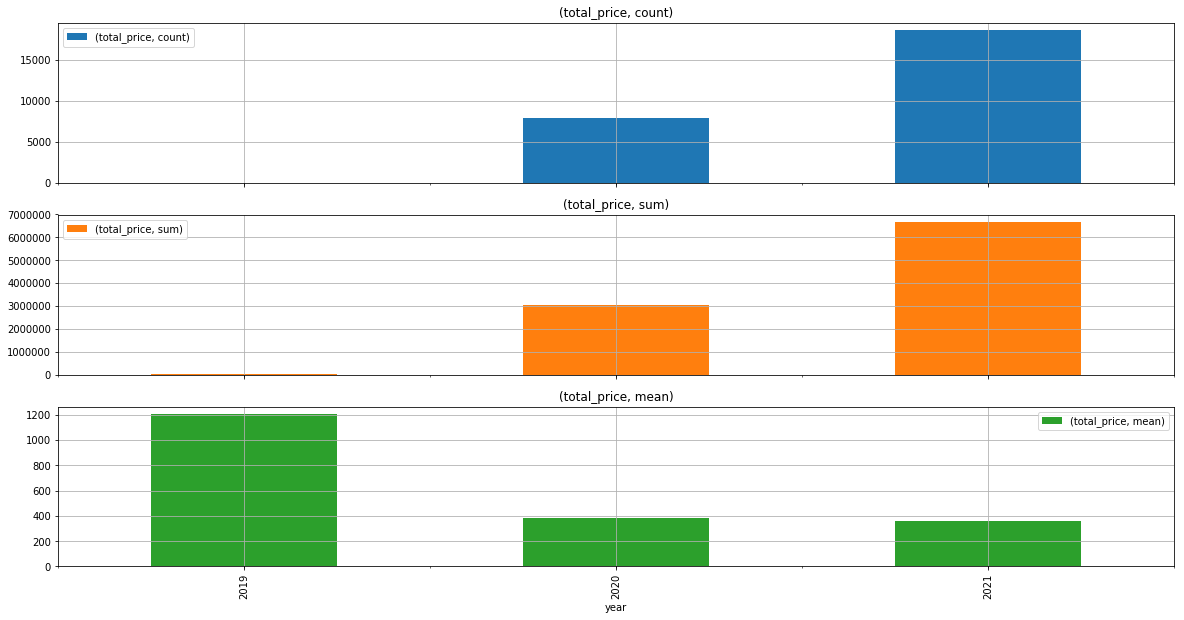

YEARMONTH


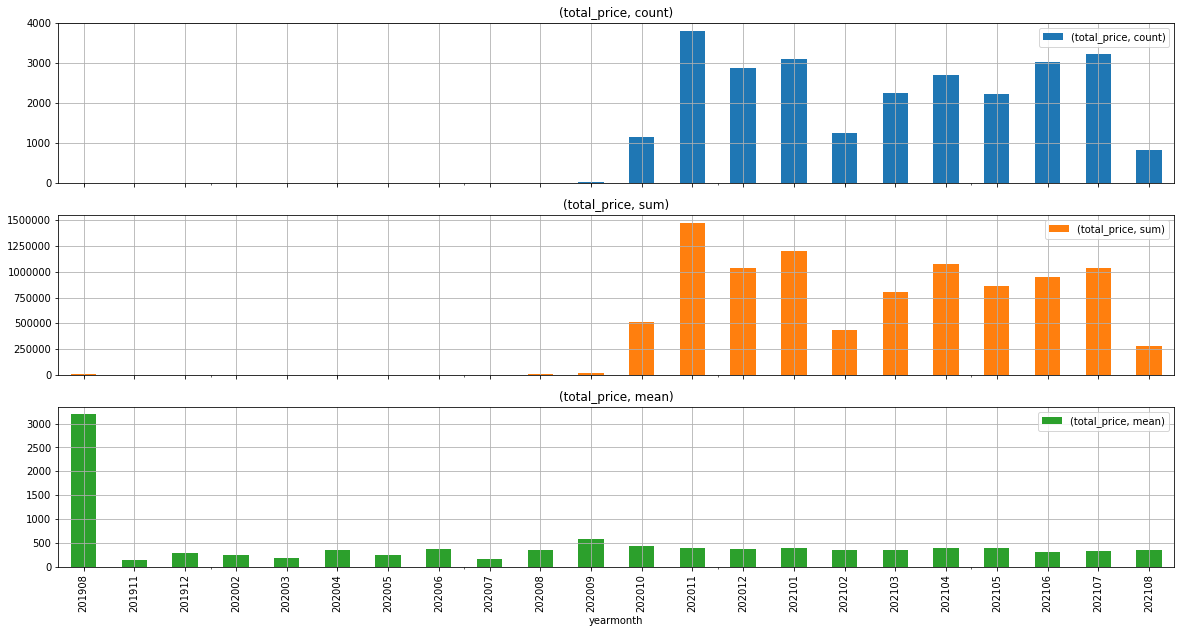

MONTH


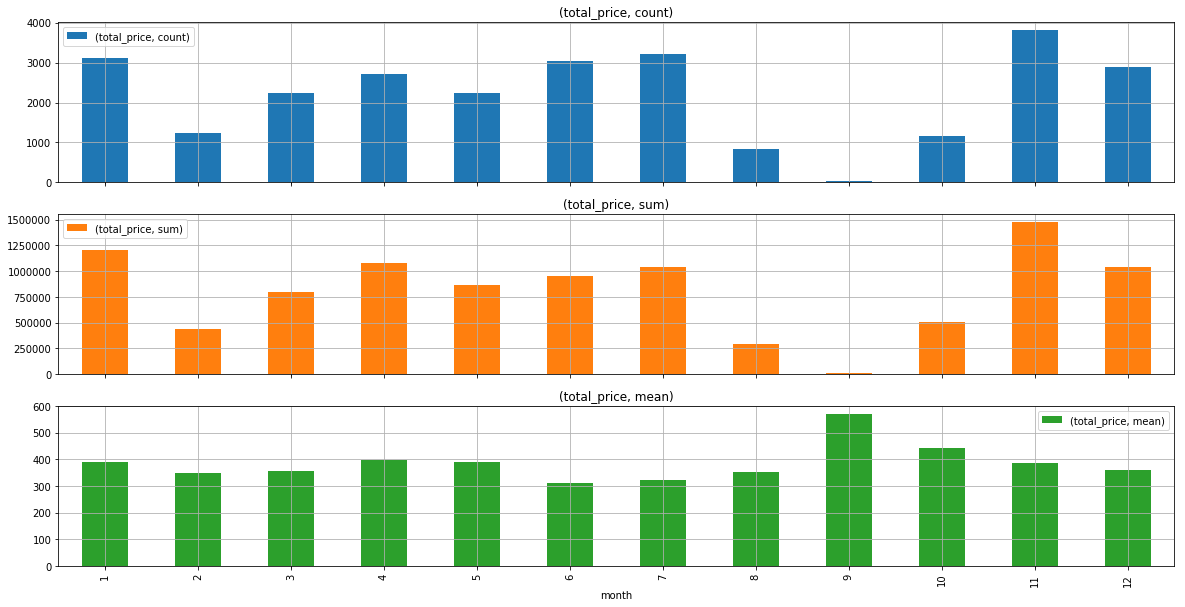

WEEK


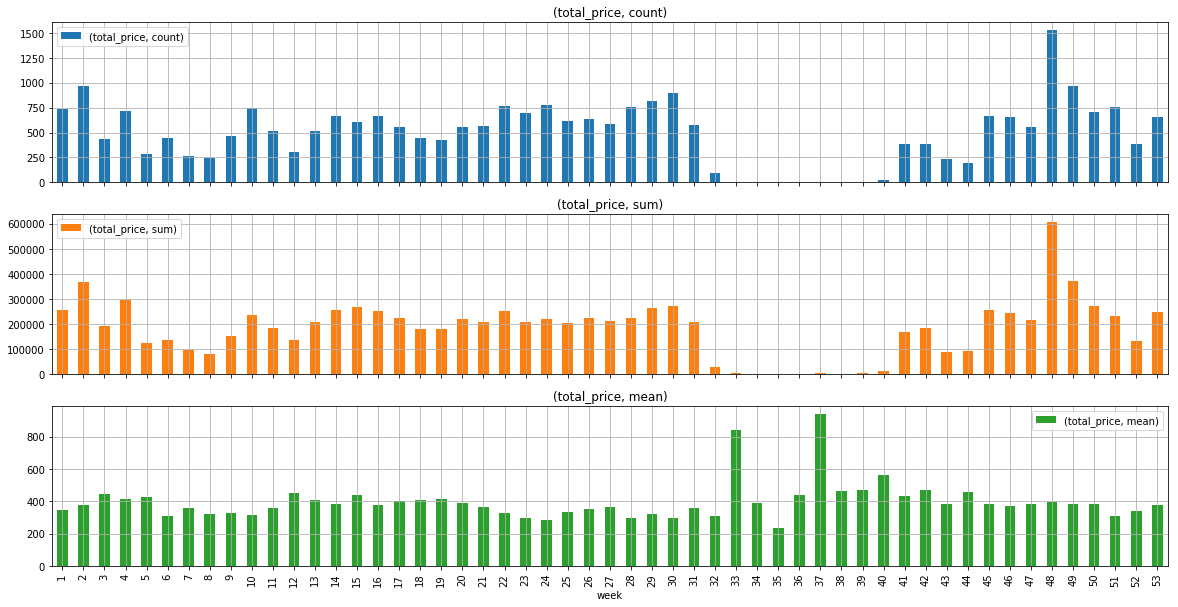

WEEKDAY


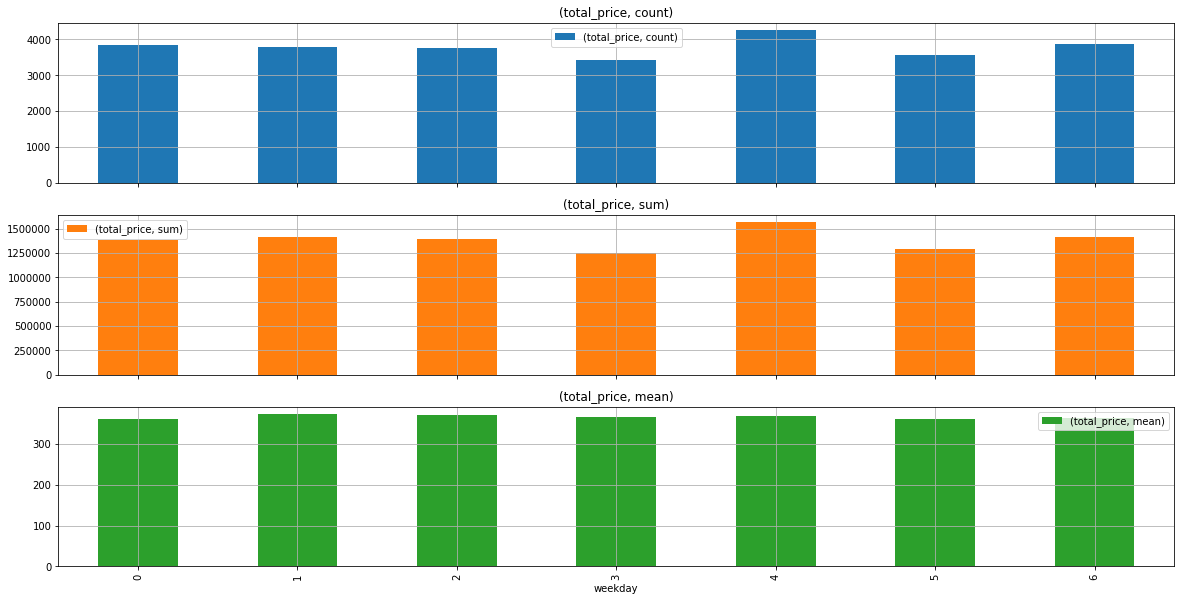

DAY


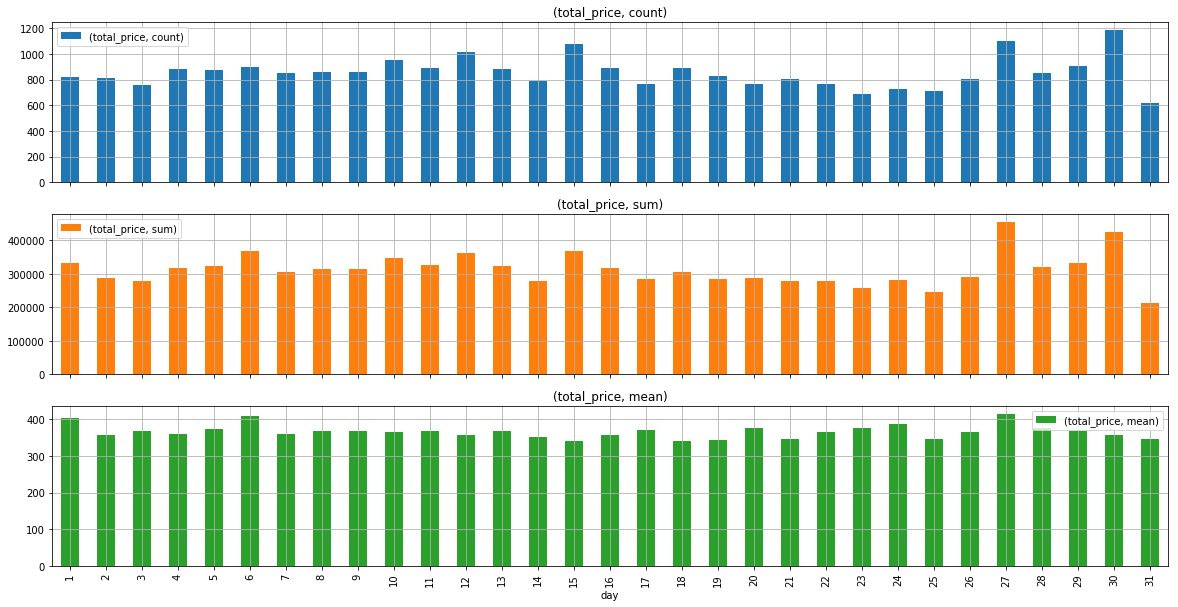

In [10]:
figsize = (20, 10)

for interval in ['year', 'yearmonth', 'month', 'week', 'weekday', 'day']:
    print('='*60)
    print(interval.upper())
    agg_df = (df[[interval, 'total_price']]
                .sort_values(by=interval)
                .groupby(interval)
                .agg(['count', 'sum', 'mean']))
    agg_df.plot(kind='bar', grid=True, subplots=True, sharex=True, figsize=figsize)
    plt.show()

Things to note:
* while in theory the dataset spans three years - 2019-21 - in practice the vast majority of activity happens between Nov 2020 and Jun 2021, giving us roughly 1.5 years of valid data

* in light of the above, any comments about seasonality in the data should be made with caution

### Geographical

The shipping and billing address are the same more tha 99% of the time:

In [13]:
(df['billing_zip'] == df['shipping_zip']).astype(int).describe()

count    26513.000000
mean         0.992683
std          0.085229
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
dtype: float64

### Segmentation

In [33]:
df[['total_price', 'segment']].groupby('segment').describe()

total_price                                                   \
              count        mean         std   min       25%      50%   
segment                                                                
1            5395.0  232.973766  126.677947   0.0  158.0000  188.000   
3           10676.0  387.466990  370.497501   0.0  187.9325  301.895   
4             914.0  988.154453  728.316570  39.0  444.0875  853.100   
6            2705.0  373.334828  328.148721   0.0  189.0000  317.000   
7             872.0  526.504989  762.894109   0.0  178.0000  318.950   
9            2964.0  273.758677  216.444979   0.0  168.0000  198.750   
10            928.0  595.596627  279.652719   0.0  445.7125  529.000   
11           2059.0  284.272846  194.192880  14.0  178.0000  227.000   

                              
               75%       max  
segment                       
1         279.1500   1518.00  
3         464.9850  13133.25  
4        1227.1875   5877.75  
6         438.9500   3480.00  
7         519.1500   9452.00  
9         318.2000   2199.00  
10        796.0000   2694.00  
11        347.0000   2370.00